## Approach
Our seventh attempt to improve default results from coursera_lab.ipynb:
- change the GAN training protocol by directly handling derivates using tf.GradientTape(), (sixth attempt)
- have the encoder and decoder models be composed of Convoluted Neural Networks
- inspired by Google tutorial (https://www.tensorflow.org/tutorials/generative/dcgan)
  


----


## Step-by-step instructions 

### Step 1: Data preprocessing 


In [1]:
%%capture
!pip install tensorflow-cpu==2.16.2

# Suppress warnings and set environment variables
import os
import numpy as np
from tensorflow.keras.datasets import mnist
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Suppress all Python warnings
warnings.filterwarnings('ignore')

# Load the MNIST dataset
(x_train, _), (_, _) = mnist.load_data()

# Normalize the pixel values to the range [-1, 1]
x_train = x_train.astype('float32') / 127.5 - 1.
x_train = np.expand_dims(x_train, axis=-1)


2025-03-16 14:50:52.571166: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-16 14:50:52.627117: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Step 2: Building the model


In [2]:
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input, Conv2D, Conv2DTranspose, Reshape, MaxPooling2D, Dropout, LeakyReLU

factor = 2

# Define the generator model 
def build_generator(): 
    model = Sequential()
    
    model.add(Dense(7*7*256, input_dim=100)) 
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(LeakyReLU(alpha=0.2)) 

    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(64*factor, (5, 5), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2DTranspose(32*factor, (5, 5), strides=(2, 2), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh')) #final image needs to be 28*28*1, so filter=1 and strides is (2*2) to multiply dimension by two from previous layer

    return model 

# Define the discriminator model 
def build_discriminator(): 
    model = Sequential() 

    model.add(Conv2D(32*factor, (5, 5), strides=(2,2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(64*factor, (5, 5), strides=(2,2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid')) 
    return model 


# Build and compile the generator 
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build and compile the discriminator
discriminator = build_discriminator() 
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

generator.summary()
discriminator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,266,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,328 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,601 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,343,681 (8.94 MB)

 Trainable params: 2,318,209 (8.84 MB)

 Non-trainable params: 25,472 (99.50 KB)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

### Step 3: Training the GAN 

#### Objective: 
- Train the GAN on the MNIST dataset. 


In [5]:
import tensorflow as tf
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss 
    return total_loss


# Training parameters 

batch_size = 64
#batch_size = 258   #google batch_size
epochs = 5000
sample_interval = 10

# Adversarial ground truths 
real = np.ones((batch_size, 1)) 
fake = np.zeros((batch_size, 1)) 

# Training loop 
for epoch in range(epochs): 
    # Train the discriminator 
    #for _ in range(x_train.shape[0]//batch_size):#sample everything on average per epoch, this is what google's tutorial does
        idx = np.random.randint(0, x_train.shape[0], batch_size) #hmm so main diff with google code is that this seems to be outside for loop and do all batches**
        real_images = x_train[idx] 
        noise = np.random.normal(0, 1, (batch_size, 100)) 
    
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = generator(noise, training=True) 

            real_output = discriminator(real_images, training=True)
            fake_output = discriminator(generated_images, training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)
    
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        # Print the progress 
        if epoch % sample_interval == 0: 
            print(f"{epoch} [D loss: {disc_loss}]  [G loss: {gen_loss}]")


0 [D loss: 1.3888044357299805]  [G loss: 0.6788032054901123]
10 [D loss: 1.053548812866211]  [G loss: 0.6266166567802429]
20 [D loss: 0.9881212711334229]  [G loss: 0.547370970249176]
30 [D loss: 1.036490559577942]  [G loss: 0.4977784752845764]
40 [D loss: 1.0704014301300049]  [G loss: 0.5153522491455078]
50 [D loss: 1.0599493980407715]  [G loss: 0.6683135032653809]
60 [D loss: 1.3195412158966064]  [G loss: 0.498264878988266]
70 [D loss: 1.3037443161010742]  [G loss: 0.5619645118713379]
80 [D loss: 1.083861231803894]  [G loss: 0.7127848863601685]
90 [D loss: 1.0412795543670654]  [G loss: 0.6752016544342041]
100 [D loss: 1.015824794769287]  [G loss: 0.7291425466537476]
110 [D loss: 1.0784504413604736]  [G loss: 0.7127937078475952]
120 [D loss: 0.9948174953460693]  [G loss: 0.8335347771644592]
130 [D loss: 0.8181041479110718]  [G loss: 0.958892822265625]
140 [D loss: 1.3757598400115967]  [G loss: 0.5458407998085022]
150 [D loss: 1.120511531829834]  [G loss: 0.7271530628204346]
160 [D loss

### Step 4: Assessing the Quality of Generated Images 

### Objective: 
- Evaluate the performance of the trained GAN. 

### 1. Qualitative Assessment: Visual Inspection


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 137.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 147.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 135.7 MB/s eta 0:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


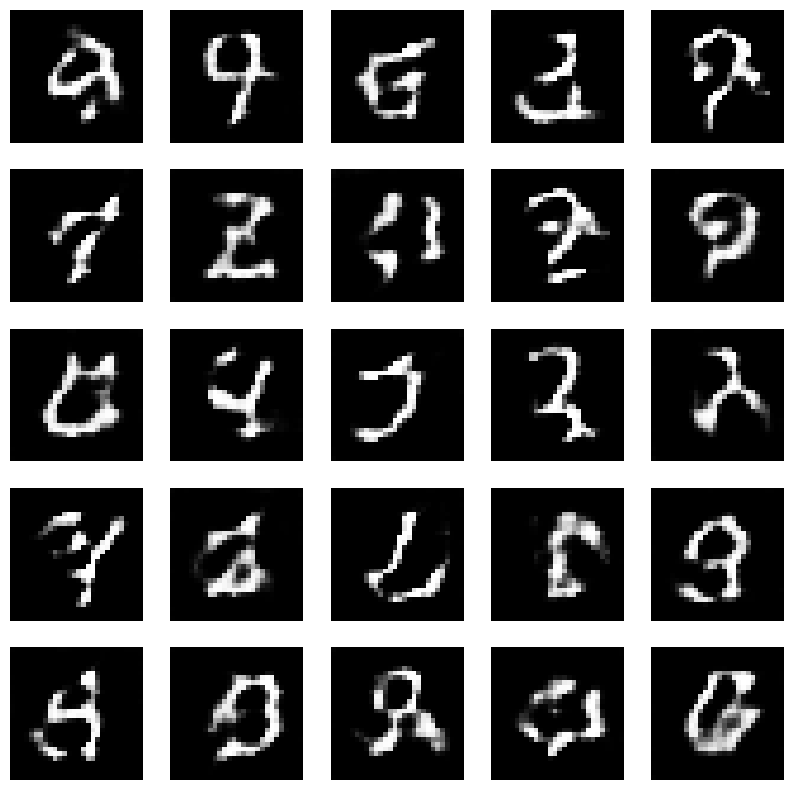

In [6]:
!pip install matplotlib
import matplotlib.pyplot as plt 

def sample_images(generator, epoch, num_images=25): 
    noise = np.random.normal(0, 1, (num_images, 100)) 
    generated_images = generator.predict(noise) 
    generated_images = 0.5 * generated_images + 0.5  # Rescale to [0, 1] 
    fig, axs = plt.subplots(5, 5, figsize=(10, 10)) 
    count = 0 

    for i in range(5): 
        for j in range(5): 
            axs[i, j].imshow(generated_images[count, :, :, 0], cmap='gray') 
            axs[i, j].axis('off') 
            count += 1 
    plt.show() 

# Sample images at the end of training 
sample_images(generator, epochs)



### 2. Quantitative Assessment: Metrics


In [7]:
# Calculate and print the discriminator accuracy on real vs. fake images
noise = np.random.normal(0, 1, (batch_size, 100))
generated_images = generator.predict(noise)

# Evaluate the discriminator on real images
real_images = x_train[np.random.randint(0, x_train.shape[0], batch_size)]
d_loss_real = discriminator.evaluate(real_images, np.ones((batch_size, 1)), verbose=0)

# Evaluate the discriminator on fake images
d_loss_fake = discriminator.evaluate(generated_images, np.zeros((batch_size, 1)), verbose=0)

print(f"Discriminator Accuracy on Real Images: {d_loss_real[1] * 100:.2f}%")
print(f"Discriminator Accuracy on Fake Images: {d_loss_fake[1] * 100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Discriminator Accuracy on Real Images: 53.12%
Discriminator Accuracy on Fake Images: 89.06%


# Summary of results 

### - Images not as blurry as DNN-based GAN architecture in try6.
- pixels of the same color aggregate more easily


Note: despite using the exact same generator and discriminator as in [Google's GAN tutorial](https://www.tensorflow.org/tutorials/generative/dcgan), results do not look as good because they train their model for longer. They train for 50 epochs but each epoch goes through all MNIST images with a batch size of 258. For my code to have similiar training with the same batch size, I would need to run my code for 60000/258 * 50 > 11,000 epochs.